<a href="https://colab.research.google.com/github/wojciechsadlik/MGU-CGANMusicConverter/blob/main/raw_audio_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter

/content/drive/MyDrive/Colab Notebooks/MGU-CGANMusicConverter


In [3]:
import os
import pickle
import numpy as np
from glob import glob
from keras.utils.np_utils import to_categorical

In [4]:
def get_data(file_list):
  def load_into(filename, x, y):
    with open(filename, 'rb') as f:
      pkl_file = pickle.load(f)
      x.append(pkl_file['audio'])
      y.append(int(pkl_file['class_id']))

  x, y = [], []
  for filename in file_list:
    load_into(filename, x, y)

  return np.array(x), np.array(y)

In [5]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, list_IDs, data_path,
                 batch_size=32, dim=(110250, 1),
                 n_channels=1, n_classes=10, shuffle=True):
        
        self.list_IDs = list_IDs
        self.data_path = data_path
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

       # Generate data
        X, y = self._generate_data(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_data(self, list_IDs_temp):
      file_list = [
        os.path.join(self.data_path, str(i) + '.pkl') for i in list_IDs_temp
      ]
      X, y = get_data(file_list)

      y = to_categorical(y, num_classes=self.n_classes)

      return X, y

In [6]:
DIR_TRAIN = './audio_splitting/output/train'
DIR_TEST = './audio_splitting/output/test'
num_classes = 10

In [7]:
train_idx = np.arange(0, 6000)
train_idx = train_idx[train_idx % 5 != 0]

test_idx = np.arange(0, 6000)
test_idx = test_idx[test_idx % 5 == 0]

In [8]:
train_generator = DataGenerator(train_idx, DIR_TRAIN)
test_generator = DataGenerator(test_idx, DIR_TEST)

In [9]:
from keras.layers.pooling import MaxPooling1D
from keras.backend import in_top_k
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras import regularizers, Input
from tensorflow.keras.layers import BatchNormalization
from keras.layers.core import Activation
from keras.layers import LeakyReLU, Add, Dense, Flatten
from tensorflow.keras.utils import plot_model

AUDIO_LENGTH = 110250

def add_Res1D(y, kernel_size, filters, strides=1, downsample=False):
  y_shortcut = y

  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)
  y = LeakyReLU()(y)
  y = Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)

  if downsample:
    y_shortcut = Conv1D(filters=filters, kernel_size=1, strides=strides, padding='same')(y_shortcut)

  y = Add()([y_shortcut, y])
  y = LeakyReLU()(y)

  return y


def classifier(input_shape=[AUDIO_LENGTH, 1], num_classes=10):

  X_input = Input(input_shape)
  
  y = Conv1D(128, kernel_size=3, strides=3, padding='same')(X_input)
  y = add_Res1D(y, 3, 128)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 128)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256, downsample=True)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 256)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = add_Res1D(y, 3, 512, downsample=True)
  y = MaxPooling1D(pool_size=3, strides=3)(y)
  y = Conv1D(512, kernel_size=1, strides=1, padding='same')(y)
  y = Flatten()(y)
  y = Dense(10, activation='softmax')(y)

  model = Model(inputs = X_input, outputs = y)
  return model

In [10]:
model = classifier()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#plot_model(model, show_shapes=True)

In [11]:
history = model.fit(train_generator, validation_data=test_generator, epochs=2)

Epoch 1/2
150/150 [==============================] - 701s 4s/step - loss: 3.4274 - accuracy: 0.4300 - val_loss: 3.3097 - val_accuracy: 0.1284
Epoch 2/2
150/150 [==============================] - 314s 2s/step - loss: 1.2371 - accuracy: 0.5802 - val_loss: 2.8455 - val_accuracy: 0.2154


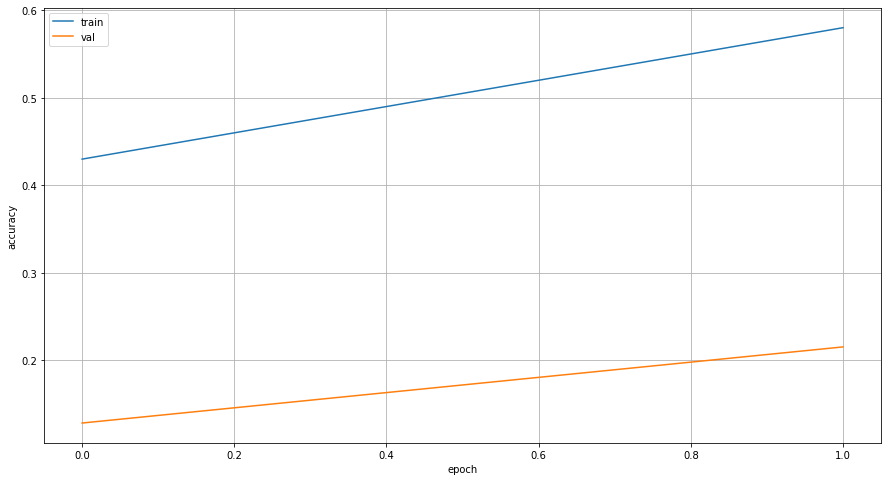

In [15]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'])
plt.show()

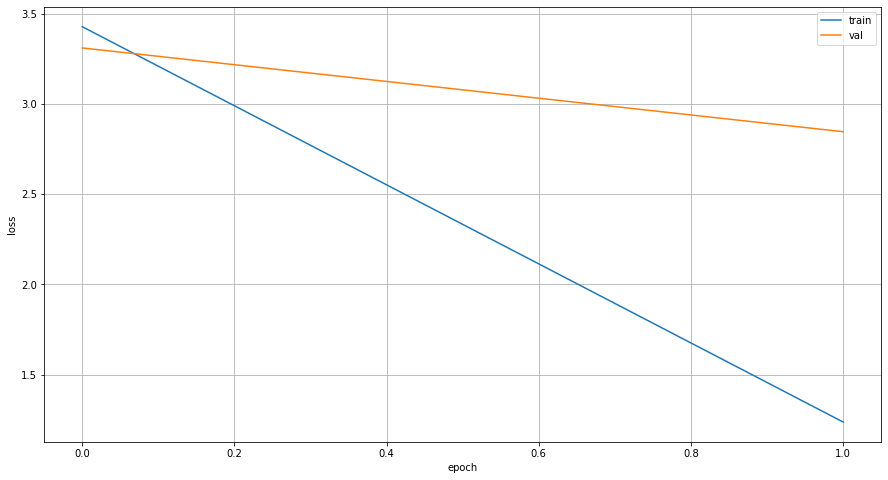

In [16]:
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['train', 'val'])
plt.show()